In [1]:
from timesteppers import IMEXEuler, IMEXSP, IMEXTrap
from RDModels import GrayScott, HeatEquation
import numpy as np
import numpy.typing as npt
from typing import Optional
import matplotlib.pyplot as plt

Solve the 1D Gray-Scott model

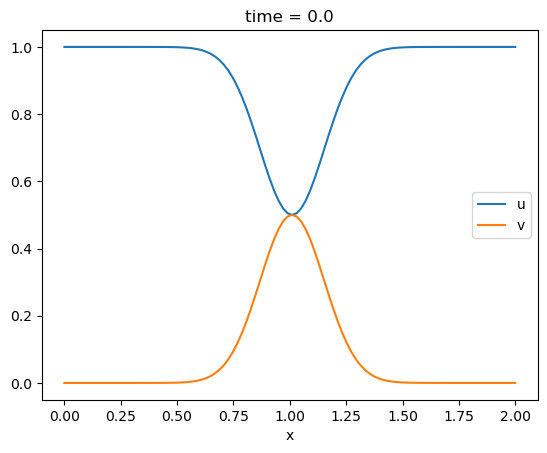

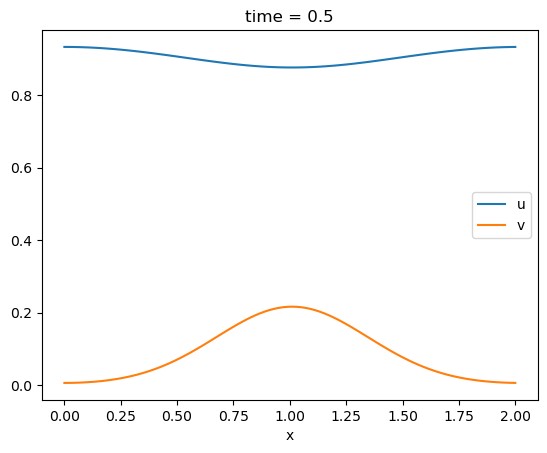

In [2]:
# discretization parameters
L: int = 2
Nx: int = 100
Nt: int = 101
discretization: npt.NDArray = np.array([Nx], dtype=int)
tmin: float = 0.0 
tmax: float = 0.5

# Model parameters
Du: float = 4e-1
Dv: float = 1e-1
F: float = 0.046
k: float = 0.063


# Initial condition
x: npt.NDArray = np.linspace(0, L, Nx, endpoint=False)
upart: npt.NDArray = np.ones((Nx, ))
vpart: npt.NDArray = np.zeros_like(upart)
perturb: npt.NDArray = np.exp(-25*np.power(x-1, 2))*0.5
upart = upart - perturb
vpart = vpart + perturb
u0: npt.NDArray = np.hstack((upart, vpart))

# Make PDE object
h1: GrayScott = GrayScott(discretization, L, Du, Dv, F, k)

# Make time stepper
imex1: IMEXEuler = IMEXEuler(h1)

# Integrate
imex1.integrate(tmin, tmax, Nt, u0)
res: Optional[npt.NDArray] = imex1.res

# Plot
imex1.plot(discretization, 0, L)
imex1.plot(discretization, -1, L)



Convergence test. Exact solution is computed using IMEX trap with a small timestep.

In [3]:
Nts: npt.NDArray = np.round(np.logspace(1, 4, 20, dtype=int))  # type: ignore 
Nx = 200
dts = (tmax - tmin)/(Nts - 1)

# Initial condition
xs: npt.NDArray = np.linspace(0, L, Nx, endpoint=False)
upart: npt.NDArray = np.ones((Nx, ))
vpart: npt.NDArray = np.zeros_like(upart)
perturb: npt.NDArray = np.exp(-25*np.power(xs-1, 2))*0.5
upart = upart - perturb
vpart = vpart + perturb
x0: npt.NDArray = np.hstack((upart, vpart))

# Make PDE object & compute exact solution
discretization: npt.NDArray = np.array([Nx])
h1: GrayScott = GrayScott(discretization, L, Du, Dv, Fvar=F, k=k)
imex3: IMEXTrap = IMEXTrap(h1)
res1 = imex3.integrate(tmin, tmax, Nts[-1]*10, x0)
exactSol: npt.NDArray = res1[-1, Nx:]

# Compute errors
err: npt.NDArray = np.zeros((Nts.size, 3), dtype=np.float64)
normType: None | str | float = np.inf
for index, Nt in enumerate(Nts):    
    # Make time steppers
    imex1: IMEXEuler = IMEXEuler(h1)
    imex2: IMEXSP = IMEXSP(h1)
    imex3: IMEXTrap = IMEXTrap(h1)
    
    # Integrate imex1
    res = imex1.integrate(tmin, tmax, Nt, x0)
    vmax: npt.NDArray = res[-1, Nx:]
    err[index, 0] = np.linalg.norm(vmax - exactSol, normType) # type: ignore

    # Integrate imex2
    res = imex2.integrate(tmin, tmax, Nt, x0)
    vmax: npt.NDArray = res[-1, Nx:]
    err[index, 1] = np.linalg.norm(vmax - exactSol, normType) # type: ignore

    # Integrate imex3
    res = imex3.integrate(tmin, tmax, Nt, x0)
    vmax: npt.NDArray = res[-1, Nx:]
    err[index, 2] = np.linalg.norm(vmax - exactSol, normType)  # type: ignore


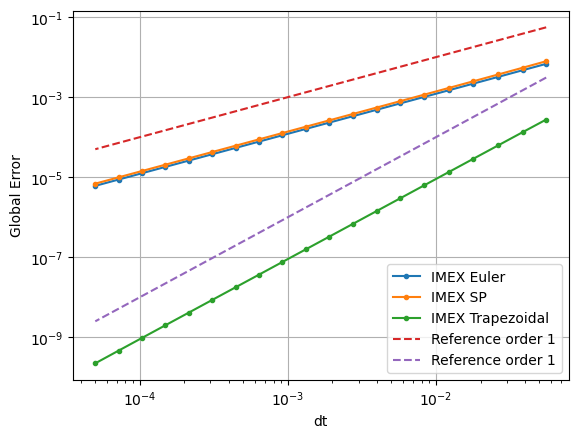

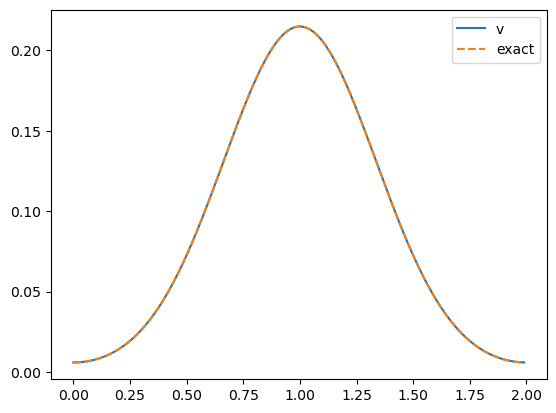

In [11]:
plt.loglog(dts, err[:, 0], '.-', label='IMEX Euler')
plt.loglog(dts, err[:, 1], '.-', label='IMEX SP')
plt.loglog(dts, err[:, 2], '.-', label='IMEX Trapezoidal')
plt.loglog(dts, dts, '--', label='Reference order 1')
plt.loglog(dts, np.power(dts, 2), '--', label='Reference order 1')
plt.xlabel('dt')
plt.ylabel('Global Error')
plt.legend()
plt.grid()
plt.savefig('Figures/Report/1dconvergence.pdf')
plt.show()

plt.figure(2)
plt.plot(xs, vmax, label='v')
plt.plot(xs, exactSol, '--', label='exact')
plt.legend()
plt.show()
